## Hyperparameter tuning

In this script, we will tune the model's hyperparameters to fit it as best as possible to the data, while avoiding overfitting. To that aim, we will try to optimise the different parameters (learning rate, batch and epoch sizes, number of layers, number of latent dimensions...) by trying different values for each and choosing the best combination of parameters, i.e. which different values work best together. 

If performing a grid search is the most exhaustive option, i.e. trying each value for each parameter and each possible combination of parameters, this is very computationally heavy and not realistic for large datasets. We will therefore use a random search, randomly exploring some combinations as to reduce the computational load. 

In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import itertools, random
import os
from tensorflow.keras.models import load_model
import json

## Data and script preparation

We will use the low-grade gliomas and glioblastoma cancer data from TCGA, which we previously preprocessed and merged. The expression data is available as `../data/merged_expression.csv`. We want to optimise the autoencoder on this bulkRNA-Seq transcriptome profiling. 

In order to tune our model, we will encapsulate the model definition and training procedure in a separate script, `tuning_ae.py` which we will call many times for each parameter combination explored. We will define the different parameters we want to tune (flags), as well as the different values we want to explore for each parameter. We also include callbacks such as early stopping and learning-rate reduction to stabilize training and avoid overfitting.

`tuning_ae.py` handles is split into 5 main functions: 
- data preparation (loading, train-test split and scaling)
- model definition 
- callbacks definition 
- model training 
- model evaluation

## Run the baseline experiment 

We first run a single configuration to establish a reference point, to which all future combinations can be compared in order to identify the best combination. We will keep track of all runs in a dedicated directory so that we can compare them later.

For our baseline run, we will choose a simple symmetric autoencoder (i.e. identical number of layers in the encoder and decoder), with two layers for both the encoder and decoder. We will use the default values for the rest of the parameters: adam optimiser, ReLU activation, 20% dropout and learning rate of 1e-3. 

The callbacks parameters (early stopping and reduce on plateau) have been fixed and won't be tuned. We will only focus on the most determining parameters as to optimise the tuning and control the computational load as much as possible.

In [4]:
# importing tuning_ae.py script 
import tuning_ae 

# update default tuning_ae.py parameters for baseline run
tuning_ae.params.update({
    "enc_units1": 512,
    "enc_units2": 128,
    "enc_units3":0
})

# baseline run
# load data
X_train, X_test, y_train, y_test = tuning_ae.load_data()

# build model using updated parameters
model = tuning_ae.build_ae(X_train, tuning_ae.params)

# train model
history = tuning_ae.train_ae(model, X_train, tuning_ae.params)

# evaluate
tuning_ae.evaluate_ae(model, X_test)


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3203


0.32025638222694397

## Explore the space 

We will now try out several parameter values and combinations using a random search, searching over 60% of the grid to keep the runtime reasonable while still exploring useful combinations. we will explore: 
- the architecture shape, looking at a symmetric vs asymmetric shape as well as a shallow vs deeper model
- the dimensions of the latent space, identifying a good trade off between compressing the data while conserving a biological meaning 
- avoiding long runtimes and overfitting 

In order to keep the search computationally fast, we will first focus on tuning the architecture shape and latent dimensions, most important parameters to tune, and then fine tune it with additional parameters. 

#### Stage 1

In [ ]:
search_space1 = {
    "enc_units1": [512, 256],
    "enc_units2": [256, 128, 0],
    "latent_dim": [16, 32, 64],
    "dec_units1": [128, 256],
    "dec_units2": [256, 0]
}

In [12]:
# defining function to retrieve parameter combinations sampled from the random search
def sample_combinations(search_space):
    # generating all combinations
    all_combinations = [dict(zip(search_space.keys(), v)) for v in itertools.product(*search_space.values())]

    #sample 60% of combinations
    sampled_combinations = random.sample(all_combinations, k=int(0.6 * len(all_combinations)))
    return sampled_combinations

In [7]:
# first search 

#generate sampled parameter combinations
sampled_combinations1 = sample_combinations(search_space1)
print(len(sampled_combinations1))

#run each sampled combination and save results
results_stage1 = []

for params in sampled_combinations1:
    tuning_ae.params.update(params)

    X_train, X_test, y_train, y_test = tuning_ae.load_data()
    model = tuning_ae.build_ae(X_train, tuning_ae.params)
    history = tuning_ae.train_ae(model, X_train, tuning_ae.params)
    val_loss = tuning_ae.evaluate_ae(model, X_test)

    # save run outcome
    results_stage1.append({
        "params": tuning_ae.params.copy(),
        "val_loss": float(val_loss),
        "model": model   # keep object in memory 
    })

# keep top-3 models by lowest validation loss
results_stage1 = sorted(results_stage1, key=lambda r: r["val_loss"])
top3 = results_stage1[:3]


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2936


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3118


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3153


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3135


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2782


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3239


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2915


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2961


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2553


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3108


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3163


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3236


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2649


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2854


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3178


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2755


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2819


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2621


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3063


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2765


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3062


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2715


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2768


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3121


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2920


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3114


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3074


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2817


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2681


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2953


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3163


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3155


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3181


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3132


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2797


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2796


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3104


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2974


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2755


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2604


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2541


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2935


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.3120


        val_loss
count  43.000000
mean    0.294162
std     0.020410
min     0.254146
25%     0.277485
50%     0.295296
75%     0.312092
max     0.323880


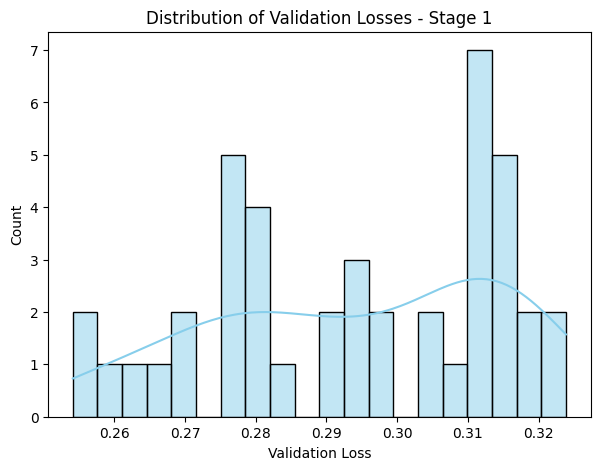

C:\Users\themi\AppData\Local\Temp\ipykernel_1376\1764322165.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param_corr.index, y=param_corr.values, palette="coolwarm")


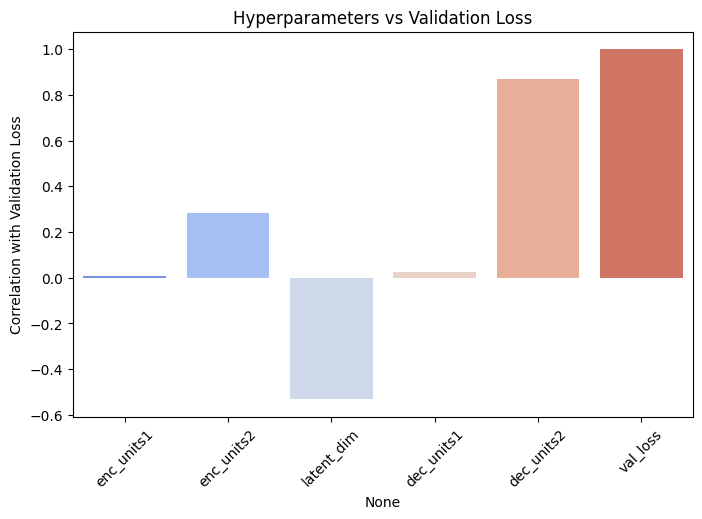

In [22]:
# investigating the tuning results
tuned_params = list(search_space1.keys())  # only these columns
results1 = pd.DataFrame([
    {k: r["params"].get(k, np.nan) for k in tuned_params} | {"val_loss": r["val_loss"]}
    for r in results_stage1
])

# exploring the distribution of validation loss
print(results1[["val_loss"]].describe())

plt.figure(figsize=(7,5))
sns.histplot(results1["val_loss"], bins=20, kde=True, color="skyblue")
plt.xlabel("Validation Loss")
plt.ylabel("Count")
plt.title("Distribution of Validation Losses - Stage 1")
plt.show()

# exploring the impact of the different hyperparameters on the validation loss 
param_corr = results1.corrwith(results1["val_loss"])

plt.figure(figsize=(8,5))
sns.barplot(x=param_corr.index, y=param_corr.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.ylabel("Correlation with Validation Loss")
plt.title("Hyperparameters vs Validation Loss")
plt.show()

43 models were evaluated during the first stage of tuning. The validation loss (calculation of MSE on the validation set) ranged between 0.25 and 0.32, with a mean of 0.29. The dimensions of the first encoder and decoder layers had no impact with the validation loss. The second layer of the encoder, and even stronger for the decoder's dimensions seemed positively correlated with the validation loss. However, the dimension of the latent space appeared negatively correlated with the validation loss. Overall, it seems that limiting the dimensions of the second encoder and decoder layers, as well as widening the latent space dimensions, would minimise the validation loss. 

We will investigate the three models with the minimum validation loss, i.e. minimal reconstruction error of the data and look at the parameters chosen. 

In [23]:
# looking at the parameters of each top3 models 
top3_df = pd.DataFrame([
    {**r["params"], "val_loss": r["val_loss"]} for r in top3
])
print(top3_df)

   enc_units1  enc_units2  enc_units3  enc_drop1  latent_dim  dec_units1  \
0         512           0           0        0.2          64         256   
1         512           0           0        0.2          64         128   
2         256           0           0        0.2          64         256   

   dec_units2  dec_units3  seed activation optimizer     lr  epochs  \
0           0           0    22       relu      adam  0.001     200   
1           0           0    22       relu      adam  0.001     200   
2           0           0    22       relu      adam  0.001     200   

   batch_size  val_split  val_loss  
0          16        0.2  0.254146  
1          16        0.2  0.255268  
2          16        0.2  0.260425  


Indeed we can see that the three most performing parameter combinations only have one layer in both the encoder and decoder. The maximum latent dimension has been chosen (64). The dropout was fixed to 0.2. 

The three top models show very similar parameters, only differing in the dimension of the first encoder and decoder layers. They also show a very similar validation loss, hence it seems that either these dimensions is suitable for our dataset. 

We will save the three top models. However, since fine-tuning is long and computationally heavy, we will only further fine tune the first model for now and see if the second tuning step further reduces the validation loss on that model. We can see later if we need to tune another.

In [ ]:
# saving the top 3 models for the next stage of tuning
save_dir = "tuning_models"
os.makedirs(save_dir, exist_ok=True)

top1 = top3[:1]

for i, r in enumerate(top1, start=1):
    model_path = os.path.join(save_dir, f"top{i}_model.keras")
    params_path = os.path.join(save_dir, f"top{i}_params.npy")

    # save model weights + structure
    r["model"].save(model_path)

    # save parameters used for this run
    np.save(params_path, r["params"], allow_pickle=True)

    print(f"Saved Top-{i}: {model_path}")

Saved Top-1: tuning_models\top1_model.keras
Saved Top-2: tuning_models\top2_model.keras
Saved Top-3: tuning_models\top3_model.keras


#### Stage 2

We now move on to the second tuning round. As mentioned, we will further fine tune the dimensions of the latent space, whose optimium might be higher than the max value of 64 set. Furthermore, we will also tune the dropout rate, learning rate and batch size, more general parameters which also influence the model's performance and should be tuned now that we have fixed the model's architecture. Since this is already a lot of parameters to tune, we will fix the optimiser to Adam and the activation to ReLU. 

In [25]:
# defining the search space for the second round of optimisation
search_space2 = {
    "latent_dim": [64, 96, 128, 256],
    "lr": [1e-3, 5e-4, 1e-4],
    "batch_size": [8, 16, 32],
    "drop1": [0.0, 0.2, 0.5] #,
    #"activation": ["relu", "tanh"],
    #"optimizer": ["adam", "rmsprop"]
}

In [34]:
# second search 

#generate sampled parameter combinations
sampled_combinations2 = sample_combinations(search_space2)
print(len(sampled_combinations2))

results_stage2 = []

for arch_result in top3[:1]: # only tuning on the top model
    arch_params = arch_result["params"]

    for train_params in sampled_combinations2:
        # merge: architecture + training hyperparams
        run_params = arch_params.copy()
        run_params.update(train_params)
        tuning_ae.params.update(run_params)

        # rerun training
        X_train, X_test, *_ = tuning_ae.load_data()
        model = tuning_ae.build_ae(X_train, tuning_ae.params)
        history = tuning_ae.train_ae(model, X_train, tuning_ae.params)
        val_loss = tuning_ae.evaluate_ae(model, X_test)

        results_stage2.append({
            "arch_id": id(arch_result),
            "params": run_params.copy(),
            "val_loss": float(val_loss)
        })

# final best model
top1_2 = min(results_stage2, key=lambda r: r["val_loss"])
print("Best config:", top1_2["params"], "loss:", top1_2["val_loss"])



64


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2958


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2978


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2781


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2524


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2843


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2406


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2340


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2416


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2789


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2744


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2435


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2793


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2764


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2495


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2513


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2475


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2310


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2488


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2766


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2972


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2380


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2408


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2336


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2824


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2862


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2499


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2526


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2481


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2809


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2440


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2438


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2424


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2536


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2428


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2469


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2550


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2823


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test reconstruction loss: 0.2801


c:\Users\themi\programming\aida\venv_aida\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

        val_loss
count  72.000000
mean    0.258671
std     0.020538
min     0.229257
25%     0.243011
50%     0.251793
75%     0.277798
max     0.302912


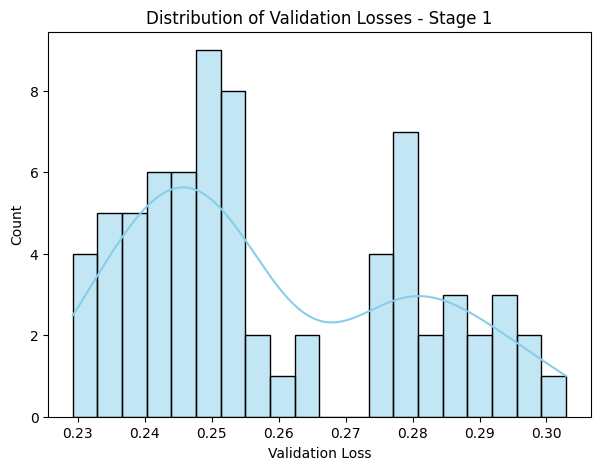

C:\Users\themi\AppData\Local\Temp\ipykernel_1376\456406365.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=param_corr.index, y=param_corr.values, palette="coolwarm")


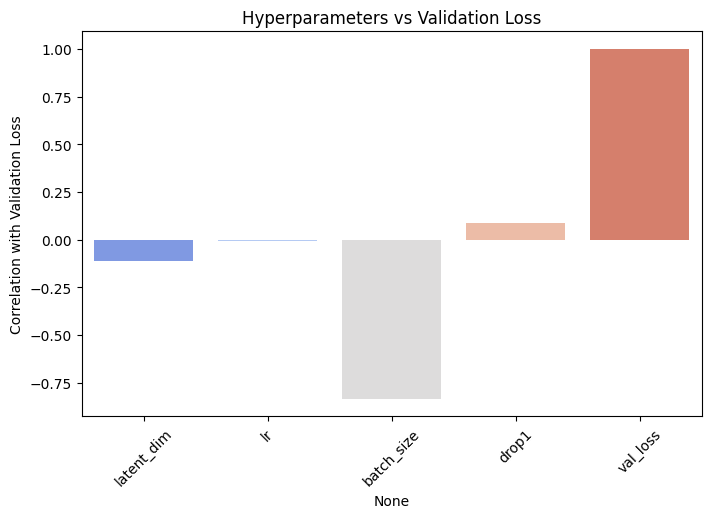

In [ ]:
# investigating the final tuning results
tuned_params = list(search_space2.keys())  # only these columns
results2 = pd.DataFrame([
    {k: r["params"].get(k, np.nan) for k in tuned_params} | {"val_loss": r["val_loss"]}
    for r in results_stage2
])

# exploring the distribution of validation loss
print(results2[["val_loss"]].describe())

plt.figure(figsize=(7,5))
sns.histplot(results2["val_loss"], bins=20, kde=True, color="skyblue")
plt.xlabel("Validation Loss")
plt.ylabel("Count")
plt.title("Distribution of Validation Losses - Stage 2")
plt.show()

# exploring the impact of the different hyperparameters on the validation loss 
param_corr = results2.corrwith(results2["val_loss"])

plt.figure(figsize=(8,5))
sns.barplot(x=param_corr.index, y=param_corr.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.ylabel("Correlation with Validation Loss")
plt.title("Hyperparameters vs Validation Loss")
plt.show()

In [ ]:
# looking at the parameters of each top3 models 
final_model_df = pd.DataFrame([{
    **top1_2["params"],
    "val_loss": top1_2["val_loss"]
}])

print(final_model_df)


   enc_units1  enc_units2  enc_units3  enc_drop1  latent_dim  dec_units1  \
0         512           0           0        0.2          96         256   

   dec_units2  dec_units3  seed activation optimizer     lr  epochs  \
0           0           0    22       relu      adam  0.001     200   

   batch_size  val_split  drop1  val_loss  
0          32        0.2    0.5  0.238846  


We can see a much narrower distribution of the validation losses for this second tuning step, which suggests that this step further fine tuned the model on some more subtle parameters. The validation loss ranged from 0.23 to 0.30, with an average of 0.26, i.e. on average better than during the first tuning step. The best model during the first step (loss = 0.254) was further improved to reach a validation loss of 0.239. 

The learning rate and dropout seemed to have very little impact on the validation loss for our model. The latent dimension showed a smaller correlation to the loss than before, suggesting that this bigger range was more suited to the data. The final model has a latent dimension of 96. The batch size, however, was strongly negatively correlated to the validation loss. The maximal batch size was chosen in the final model. 

Since we do not know if a batch size of 32 is optimal, or if it was just the maximal value suggested in the model, we will perform a third round of tuning, only trying bigger values for the batch size. 

In [ ]:
# saving the top model for the final stage of tuning
for i, r in enumerate(top1_2, start=1):
    model_path = os.path.join(save_dir, f"top{i}_model_stage2.keras")
    params_path = os.path.join(save_dir, f"top{i}_params_stage2.npy")

    # save model weights + structure
    r["model"].save(model_path)

    # save parameters used for this run
    np.save(params_path, r["params"], allow_pickle=True)

    print(f"Saved Top-{i}: {model_path}")

#### Stage 3 

As mentioned, we will finally perform a last tuning of the batch size, since it seemed to have an impact on the validation loss for our data. 

In [ ]:
# defining the explored batch sizes 
batch_sizes = [32, 64, 128]

In [ ]:
# third search (based on the previous model)

batch_results = []

X_train, X_test, _, _ = tuning_ae.load_data()

for bs in batch_sizes:
    # update parameters: batch size only
    tuning_ae.params.update(top1_2["params"])  # keep architecture & other params
    tuning_ae.params["batch_size"] = bs

    # build new model with the same architecture
    model = tuning_ae.build_ae(X_train, tuning_ae.params)

    # train model
    history = tuning_ae.train_ae(model, X_train, tuning_ae.params)

    # evaluate
    val_loss = tuning_ae.evaluate_ae(model, X_test)

    batch_results.append({
        "batch_size": bs,
        "val_loss": val_loss,
        "model": model
    })
    print(f"Batch size {bs}: val_loss={val_loss:.4f}")



In [ ]:
best_batch = min(batch_results, key=lambda r: r["val_loss"])
print("Best batch size:", best_batch["batch_size"], "Val loss:", best_batch["val_loss"])

We have now optimised the important hyperparameters of our autoencoder, which seems to perform well on the data, with a validation loss of... 

Now, we will keep those optimal parameters to retrain our model and save it. 

## Retraining the best configuration

Based on the tuning, we will train a fresh model with the set of chosen parameters. 

In [ ]:
# ----------------------
# 1. Load data
# ----------------------
X_train, X_test, y_train, y_test = tuning_ae.load_data()

# ----------------------
# 2. Build model with best parameters
# ----------------------
best_params = best_batch["params"]  # from the last model
tuning_ae.params.update(best_params)
final_model = tuning_ae.build_ae(X_train, tuning_ae.params)

# ----------------------
# 3. Train the model
# ----------------------
final_history = tuning_ae.train_ae(final_model, X_train, tuning_ae.params)

# ----------------------
# 4. Evaluate
# ----------------------
final_loss = tuning_ae.evaluate_ae(final_model, X_test)
print(f"Final model test loss: {final_loss:.4f}")

## Saving and reloading the final model 

Finally, we save the model. We will also extract the latent space as well as the reconstruction of the data, in order to save all the information and enable a clear, reproducible analysis of the results. 

We also reload the model and re-evaluate it on the test data to make sure that saving the model went well and our model can be used in other scripts. 


In [ ]:
# ----------------------
# 5. Save model + parameters
# ----------------------
os.makedirs("final_model", exist_ok=True)

final_model.save("final_model/final_autoencoder.keras")

with open("final_model/final_params.json", "w") as f:
    json.dump(best_params, f, indent=2)

print("Saved final model and parameters.")

# ----------------------
# 6. Save latent embeddings
# ----------------------
encoder = final_model.get_layer("latent")
Z_train = encoder.predict(X_train)
Z_test  = encoder.predict(X_test)

np.save("final_model/final_Z_train.npy", Z_train)
np.save("Final_model/final_Z_test.npy", Z_test)
print("Saved latent embeddings.")

# ----------------------
# 7. Save reconstructions
# ----------------------
X_train_rec = final_model.predict(X_train)
X_test_rec  = final_model.predict(X_test)

np.save("final_model/final_X_train_rec.npy", X_train_rec)
np.save("final_model/final_X_test_rec.npy", X_test_rec)
print("Saved reconstructions.")

In [ ]:
reloaded = load_model("final_model/final_autoencoder.keras")
reloaded.evaluate(X_test, X_test)

We can see that the test performance on our test set is similar/identical to previously. Our model has been correctly saved and can be used for further analysis. 